Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import gc
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, plot_confusion_matrix, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [26]:
# Read in the data sets
X_train = pd.read_csv("data/X_train.csv").set_index('Unnamed: 0')
X_test = pd.read_csv("data/X_test.csv").set_index('Unnamed: 0')
y_train = pd.read_csv("data/y_train.csv").set_index('Unnamed: 0')
y_test = pd.read_csv("data/y_test.csv").set_index('Unnamed: 0')

In [27]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(
    steps=[("num_imputer", SimpleImputer(strategy="median")), ("scaler", MinMaxScaler())]
)

categorical_features = X_train.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(
    steps=[("cat_imputer", SimpleImputer(strategy="most_frequent")), ("ohe", OneHotEncoder(handle_unknown = 'ignore'))]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [28]:
preproc = Pipeline(
    steps=[("preprocessor", preprocessor)]
)

X_train_proc = preproc.fit_transform(X_train)
X_test_proc = preproc.transform(X_test)

In [29]:
X_train_proc.shape

(20000, 71)

In [30]:
X_train.columns

Index(['birth_place', 'mother_age', 'mother_native', 'mother_race',
       'mother_hispanic', 'marital_status', 'mother_education', 'father_age',
       'living_children', 'deceased_children', 'terminations',
       'months_prenatal_care', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
       'down_syndrome'],
      dtype='object')

## Logistic Regression

In [40]:
logpipe = Pipeline([
    ('logistic', LogisticRegression())
])

# Parameters for the grid search
parameters = {
    'logistic__C': [1, 10, 100],
    'logistic__max_iter': [1000],
    'logistic__random_state': [27],
    'logistic__solver': ['sag', 'saga']
}

# Perform grid search prioritizing precision
grid_log = GridSearchCV(logpipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_log.fit(X_train_proc, y_train.values.ravel())

print(grid_log.best_score_)
print(grid_log.best_params_)

0.73122555
{'logistic__C': 10, 'logistic__max_iter': 1000, 'logistic__random_state': 27, 'logistic__solver': 'sag'}


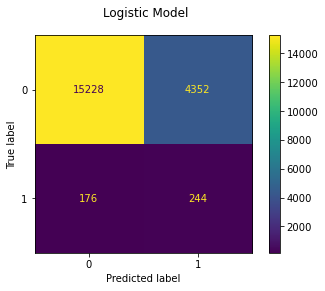

In [32]:
# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Logistic Model")

plot_confusion_matrix(grid_log, X_test_proc, y_test, ax=ax, values_format='');

## KNNeighbors Classifier

In [39]:
knnpipe = Pipeline([
    ('knn', KNeighborsClassifier())
])

# Parameters for the grid search
parameters = {
    'knn__n_neighbors': [5], # Tried: 2-10
    'knn__leaf_size': [10, 15, 20, 25] # Tried: 30, 50, 100
}

# Perform grid search prioritizing precision
grid_knn = GridSearchCV(knnpipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_knn.fit(X_train_proc, y_train.values.ravel())

print(grid_knn.best_score_)
print(grid_knn.best_params_)

0.6462462750000001
{'knn__leaf_size': 10, 'knn__n_neighbors': 5}


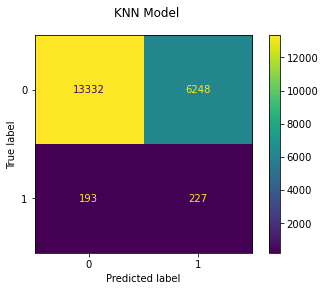

In [41]:
# Confusion matrix for the KNN model
fig, ax = plt.subplots()

fig.suptitle("KNN Model")

plot_confusion_matrix(grid_knn, X_test_proc, y_test, ax=ax, values_format='');

## Decision Tree Classifier

In [54]:
treepipe = Pipeline([
    ('tree', DecisionTreeClassifier())
])

# Parameters for the grid search
parameters = {
    'tree__criterion': ['entropy'], # Tried: gini, log_loss
    'tree__max_depth': [7], # Tried: 2-20
    'tree__min_samples_split': [2], # Tried: 2-50
    'tree__min_samples_leaf': [210], # Tried: 2-300
    'tree__random_state': [27]
}

# Perform grid search prioritizing precision
grid_tree = GridSearchCV(treepipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_tree.fit(X_train_proc, y_train.values.ravel())

print(grid_tree.best_score_)
print(grid_tree.best_params_)

0.7332904499999999
{'tree__criterion': 'entropy', 'tree__max_depth': 7, 'tree__min_samples_leaf': 210, 'tree__min_samples_split': 2, 'tree__random_state': 27}


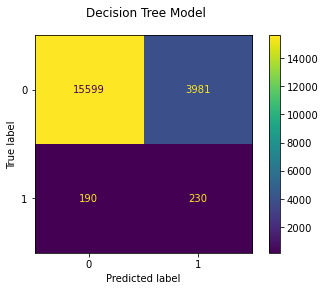

In [55]:
# Confusion matrix for the Tree model
fig, ax = plt.subplots()

fig.suptitle("Decision Tree Model")

plot_confusion_matrix(grid_tree, X_test_proc, y_test, ax=ax, values_format='');

## Random Forest

In [67]:
forestpipe = Pipeline([
    ('forest', RandomForestClassifier())
])

# Parameters for the grid search
parameters = {
    'forest__n_estimators': [245], # Tried: 2-300
    'forest__criterion': ['gini'], # Tried: entropy
    'forest__min_samples_split': [6], # Tried: 2-20
    'forest__max_depth': [15], # Tried: 2-50
    'forest__random_state': [27]
}

# Perform grid search prioritizing precision
grid_forest = GridSearchCV(forestpipe, param_grid=parameters, scoring='roc_auc')

# Fit grid search and predict
grid_forest.fit(X_train_proc, y_train.values.ravel())

print(grid_forest.best_score_)
print(grid_forest.best_params_)

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\sklearn\pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\sklearn\ensemble\_forest.py", line 386, in fit
    trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
  File "C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\joblib\parallel.py", line 1048, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Patrick\anaconda3\envs\lear

0.7506622000000001
{'forest__criterion': 'gini', 'forest__max_depth': 15, 'forest__min_samples_split': 6, 'forest__n_estimators': 245, 'forest__random_state': 27}


## XGBoost

In [76]:
boostpipe = Pipeline([
    ('boost', xgboost.XGBClassifier())
])

# Parameters for grid search
parameters = {
    'boost__max_depth': [2], # Tried: 2-5
    'boost__min_child_weight': [20], # Tried: 1-50
    'boost__gamma': [1], # Tried: 0.5-5
    'boost__n_estimators': [65], # Tried: 5-75
    'boost__random_state': [27]
}

# Grid search with boost model
grid_boost = GridSearchCV(boostpipe, param_grid=parameters, scoring='roc_auc')

# Fit model and generate predictions
grid_boost.fit(X_train_proc, y_train.values.ravel())

print(grid_boost.best_score_)
print(grid_boost.best_params_)

0.7535994500000001
{'boost__gamma': 1, 'boost__max_depth': 2, 'boost__min_child_weight': 20, 'boost__n_estimators': 65, 'boost__random_state': 27}


In [77]:
# y_test_boost = grid_boost.predict(X_test_proc)
# print(recall_score(y_test, y_test_boost))

0.5666666666666667


In [163]:
dummy_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", DummyClassifier(strategy='most_frequent'))]
)

dummy_clf.fit(X_train, y_train)
print("Model score: %.3f" % dummy_clf.score(X_test, y_test))

Model score: 0.979


In [164]:
y_pred_dummy = dummy_clf.predict(X_test)

In [165]:
print(recall_score(y_test, y_pred_dummy))

0.0


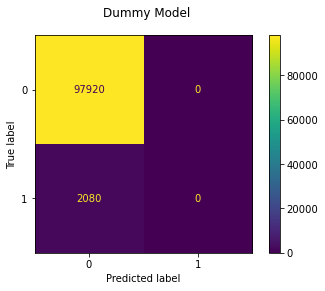

In [166]:
# Confusion matrix for the dummy model
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_clf, X_test, y_test, ax=ax, values_format='');


In [167]:
log_clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(random_state=27, max_iter=1000))]
)

log_clf.fit(X_train, y_train)
print("Model score: %.3f" % log_clf.score(X_test, y_test))

Model score: 0.780


Business Metric: Recall

In [168]:
y_pred_log = log_clf.predict(X_test)
print(recall_score(y_test, y_pred_log))

0.5649038461538461


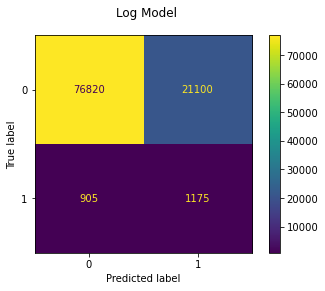

In [169]:
# Confusion matrix for the logistic model
fig, ax = plt.subplots()

fig.suptitle("Log Model")

plot_confusion_matrix(log_clf, X_test, y_test, ax=ax, values_format='');
